## Preparation of the data

Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

In [2]:
import os
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive\annotations\Cars0.xml
archive\annotations\Cars1.xml
archive\annotations\Cars10.xml
archive\annotations\Cars100.xml
archive\annotations\Cars101.xml
archive\annotations\Cars102.xml
archive\annotations\Cars103.xml
archive\annotations\Cars104.xml
archive\annotations\Cars105.xml
archive\annotations\Cars106.xml
archive\annotations\Cars107.xml
archive\annotations\Cars108.xml
archive\annotations\Cars109.xml
archive\annotations\Cars11.xml
archive\annotations\Cars110.xml
archive\annotations\Cars111.xml
archive\annotations\Cars112.xml
archive\annotations\Cars113.xml
archive\annotations\Cars114.xml
archive\annotations\Cars115.xml
archive\annotations\Cars116.xml
archive\annotations\Cars117.xml
archive\annotations\Cars118.xml
archive\annotations\Cars119.xml
archive\annotations\Cars12.xml
archive\annotations\Cars120.xml
archive\annotations\Cars121.xml
archive\annotations\Cars122.xml
archive\annotations\Cars123.xml
archive\annotations\Cars124.xml
archive\annotations\Cars125.xml
archive\annotat

We create the variable X containing all the images of cars by resizing them.



In [3]:
IMAGE_SIZE = 224

In [4]:
img_dir = "archive/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [5]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [6]:
path = 'archive/annotations'
text_files = ['archive/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [7]:
resizeannotation("archive/annotations/Cars147.xml")

[188, 141, 101, 104]

In [8]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [9]:
np.array(X).shape

(433, 224, 224, 3)

In [10]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

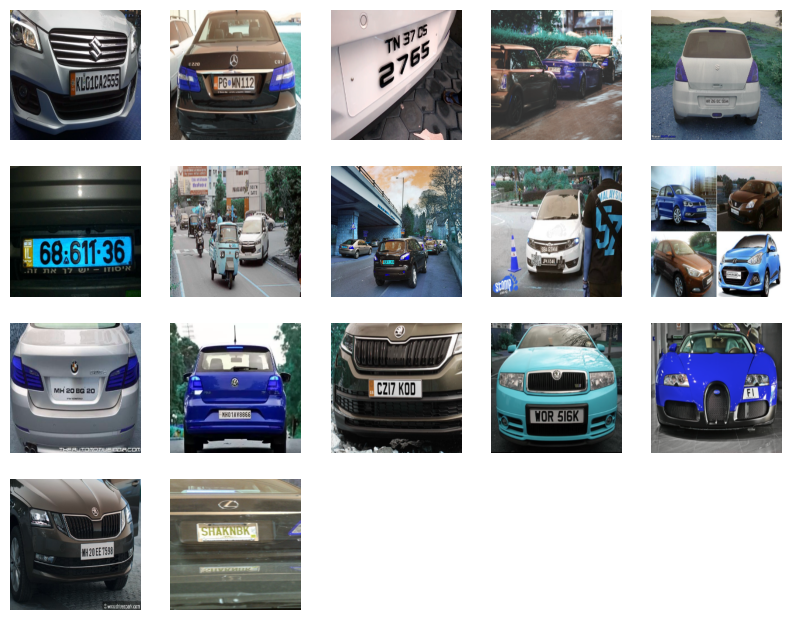

In [11]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

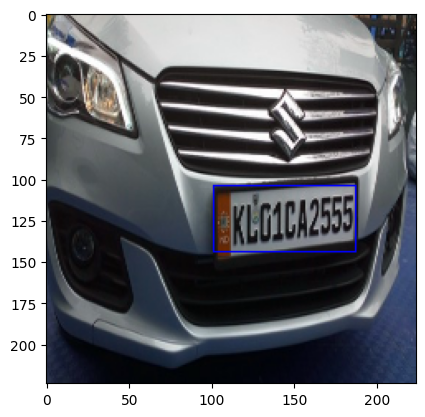

In [12]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


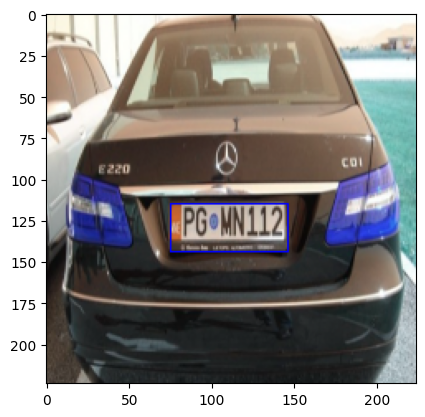

In [13]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [14]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [15]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [17]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [18]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17951108 (68.48 MB)
Trainable params: 32

In [19]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [20]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50


10/10 [==============================] - 46s 4s/step - loss: 0.0934 - accuracy: 0.4373 - val_loss: 0.0239 - val_accuracy: 0.5143
Epoch 2/50
10/10 [==============================] - 38s 4s/step - loss: 0.0272 - accuracy: 0.5113 - val_loss: 0.0263 - val_accuracy: 0.2000
Epoch 3/50
10/10 [==============================] - 41s 4s/step - loss: 0.0116 - accuracy: 0.6174 - val_loss: 0.0181 - val_accuracy: 0.4857
Epoch 4/50
10/10 [==============================] - 39s 4s/step - loss: 0.0056 - accuracy: 0.7235 - val_loss: 0.0167 - val_accuracy: 0.6286
Epoch 5/50
10/10 [==============================] - 39s 4s/step - loss: 0.0029 - accuracy: 0.8296 - val_loss: 0.0151 - val_accuracy: 0.6286
Epoch 6/50
10/10 [==============================] - 40s 4s/step - loss: 0.0018 - accuracy: 0.8617 - val_loss: 0.0152 - val_accuracy: 0.7143
Epoch 7/50
10/10 [==============================] - 38s 4s/step - loss: 0.0011 - accuracy: 0.9389 - val_loss: 0.0152 - val_accuracy: 0.7429
Epoch 8/50
10/10 [

In [21]:
model.save('models/my_model.h5', overwrite=True) 

d:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 87.36%


In [23]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

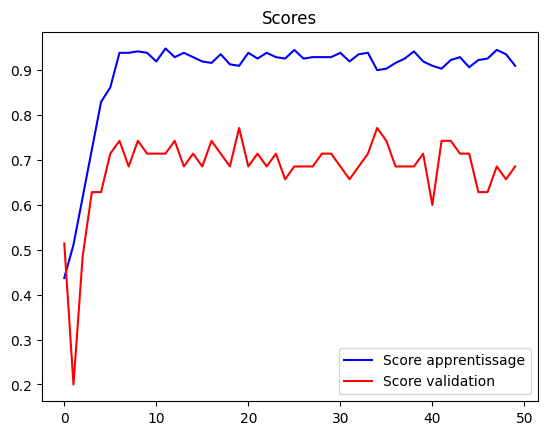

In [24]:
plot_scores(train)

## DETECTION 

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


100/100 [==============================] - 14s 136ms/step - loss: 0.0589 - accuracy: 0.7471
Test results 
 Loss: 0.05892599746584892 
 Accuracy 0.7471264600753784


In [30]:
y_cnn = model.predict(X_test)

3/3 [==============================] - 11s 3s/step


We can see how our model localize license plates on our testing set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

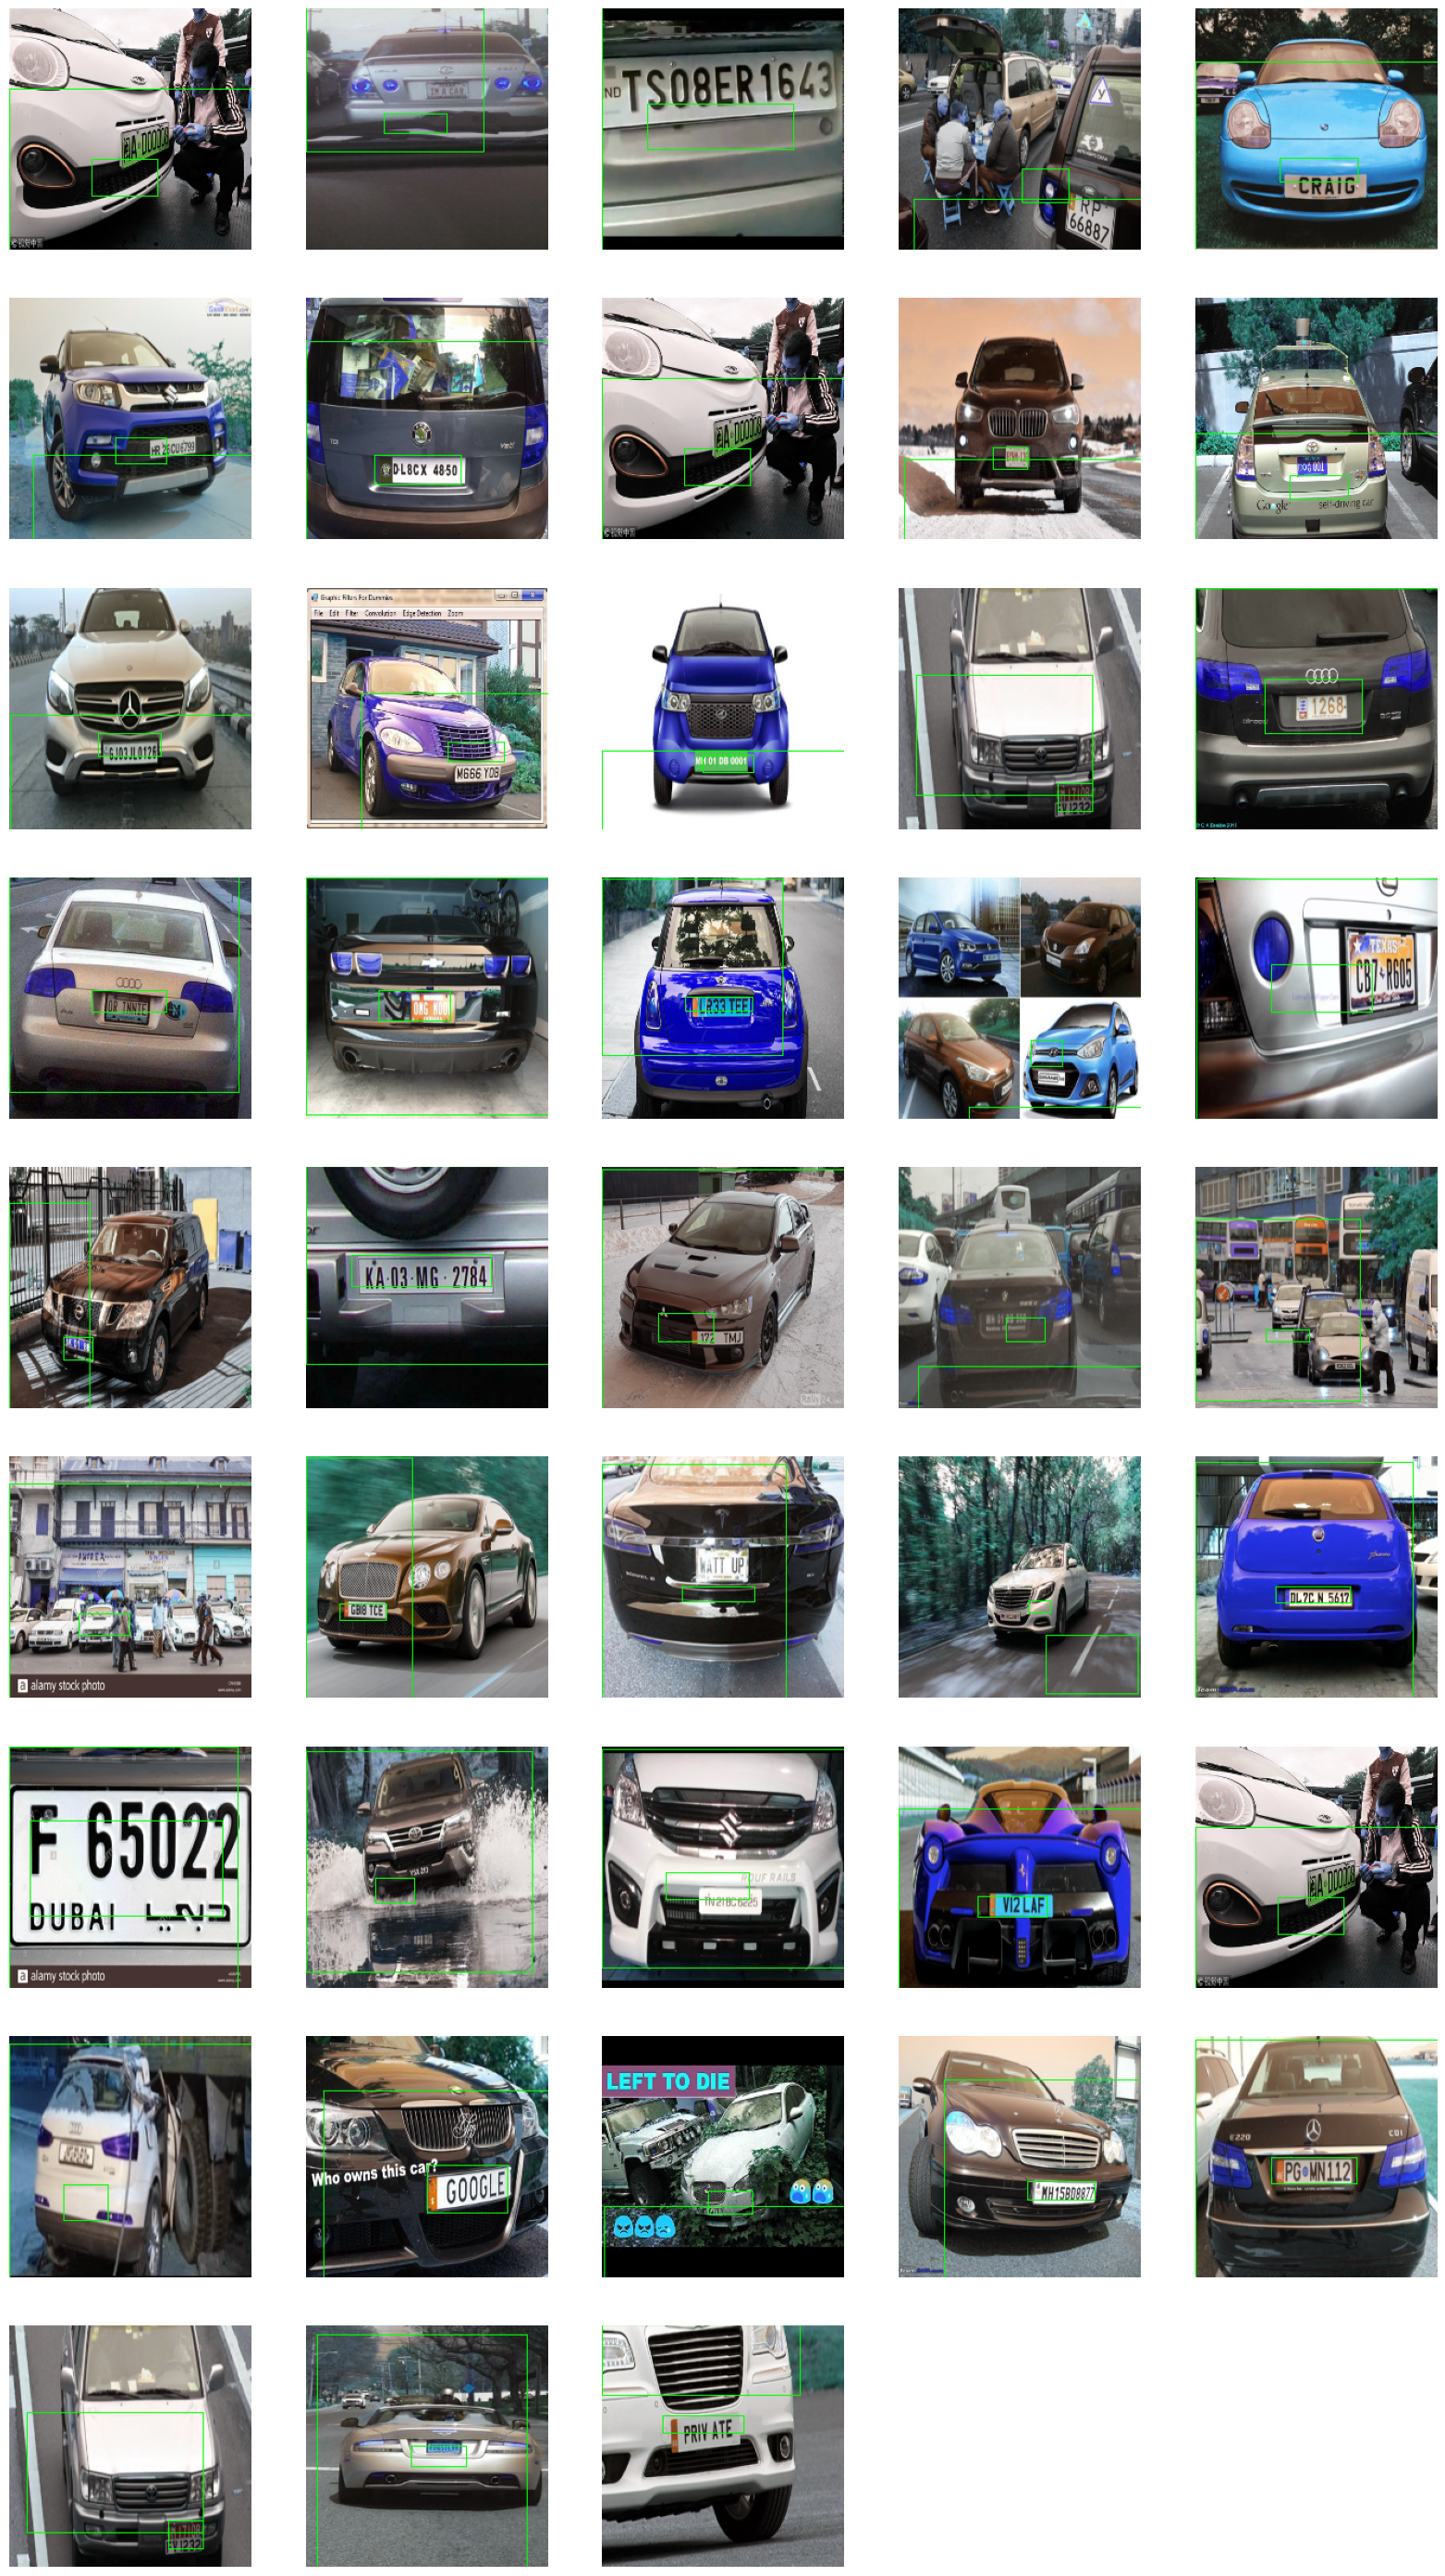

In [31]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

